In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/MyDrive/pcos_self_diagnosis_dataset" "/content/"

In [ ]:
# Load datasets
PCOS_inf = pd.read_csv('pcos_self_diagnosis_dataset/PCOS_infertility.csv')
PCOS_woinf = pd.read_excel('pcos_self_diagnosis_dataset/PCOS_data_without_infertility.xlsx')

In [ ]:
# Merging the two files as per patient file no.
# The files were sorted into two based on patients with infertility and without infertility
data = pd.merge(
    PCOS_woinf,
    PCOS_inf,
    on='Patient File No.',
    suffixes=('', '_y'),  # Changed from {'','_y'} to ('', '_y')
    how='left'
)

# Dropping the repeated features after merging
data = data.drop([
    'Unnamed: 44',
    'Sl. No_y',
    'PCOS (Y/N)_y',
    '  I   beta-HCG(mIU/mL)_y',
    'II    beta-HCG(mIU/mL)_y',
    'AMH(ng/mL)_y'
], axis=1)

# Taking a look at the dataset
data.head()

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,1,1,0,28,44.6,152.0,19.3,15,78,22,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,2,2,0,36,65.0,161.5,NaN,15,74,20,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,3,3,1,33,68.8,165.0,NaN,11,72,18,...,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,4,4,0,37,65.0,148.0,NaN,13,72,20,...,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,5,5,0,25,52.0,161.0,NaN,11,72,18,...,0,0.0,0,120,80,3,4,16.0,14.0,7.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sl. No                  541 non-null    int64  
 1   Patient File No.        541 non-null    int64  
 2   PCOS (Y/N)              541 non-null    int64  
 3    Age (yrs)              541 non-null    int64  
 4   Weight (Kg)             541 non-null    float64
 5   Height(Cm)              541 non-null    float64
 6   BMI                     242 non-null    float64
 7   Blood Group             541 non-null    int64  
 8   Pulse rate(bpm)         541 non-null    int64  
 9   RR (breaths/min)        541 non-null    int64  
 10  Hb(g/dl)                541 non-null    float64
 11  Cycle(R/I)              541 non-null    int64  
 12  Cycle length(days)      541 non-null    int64  
 13  Marraige Status (Yrs)   540 non-null    float64
 14  Pregnant(Y/N)           541 non-null    in

In [ ]:
data["AMH(ng/mL)"].head()


,AMH(ng/mL)
0,2.07
1,1.53
2,6.63
3,1.22
4,2.26


In [ ]:
#Similarly

data["II    beta-HCG(mIU/mL)"].head()

,II beta-HCG(mIU/mL)
0,1.99
1,1.99
2,494.08
3,1.99
4,801.45


In [ ]:
#Dealing with categorical values.
#In this database the type objects are numeric values saved as strings.
#So I am just converting it into a numeric value.

data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')
data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')

#Dealing with missing values.
#Filling NA values with the median of that feature.

data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(),inplace=True)
data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(),inplace=True)
data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(),inplace=True)
data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(),inplace=True)

#Clearing up the extra space in the column names (optional)

data.columns = [col.strip() for col in data.columns]

In [ ]:
data.describe()

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
count,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,242.000000,541.000000,541.000000,541.000000,...,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000
mean,271.000000,271.000000,0.327172,31.430684,59.637153,156.484835,23.929752,13.802218,73.247689,19.243993,...,0.489834,0.515712,0.247689,114.661738,76.927911,6.129390,6.641405,15.018115,15.451701,8.475915
std,156.317519,156.317519,0.469615,5.411006,11.028287,6.033545,3.663177,1.840812,4.430285,1.688629,...,0.500359,0.500216,0.432070,7.384556,5.574112,4.229294,4.436889,3.566839,3.318848,2.165381
min,1.000000,1.000000,0.000000,20.000000,31.000000,137.000000,15.100000,11.000000,13.000000,16.000000,...,0.000000,0.000000,0.000000,12.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,136.000000,136.000000,0.000000,28.000000,52.000000,152.000000,21.900000,13.000000,72.000000,18.000000,...,0.000000,0.000000,0.000000,110.000000,70.000000,3.000000,3.000000,13.000000,13.000000,7.000000
50%,271.000000,271.000000,0.000000,31.000000,59.000000,156.000000,24.000000,14.000000,72.000000,18.000000,...,0.000000,1.000000,0.000000,110.000000,80.000000,5.000000,6.000000,15.000000,16.000000,8.500000
75%,406.000000,406.000000,1.000000,35.000000,65.000000,160.000000,25.975000,15.000000,74.000000,20.000000,...,1.000000,1.000000,0.000000,120.000000,80.000000,9.000000,10.000000,18.000000,18.000000,9.800000
max,541.000000,541.000000,1.000000,48.000000,108.000000,180.000000,38.900000,18.000000,82.000000,28.000000,...,1.000000,1.000000,1.000000,140.000000,100.000000,22.000000,20.000000,24.000000,24.000000,18.000000


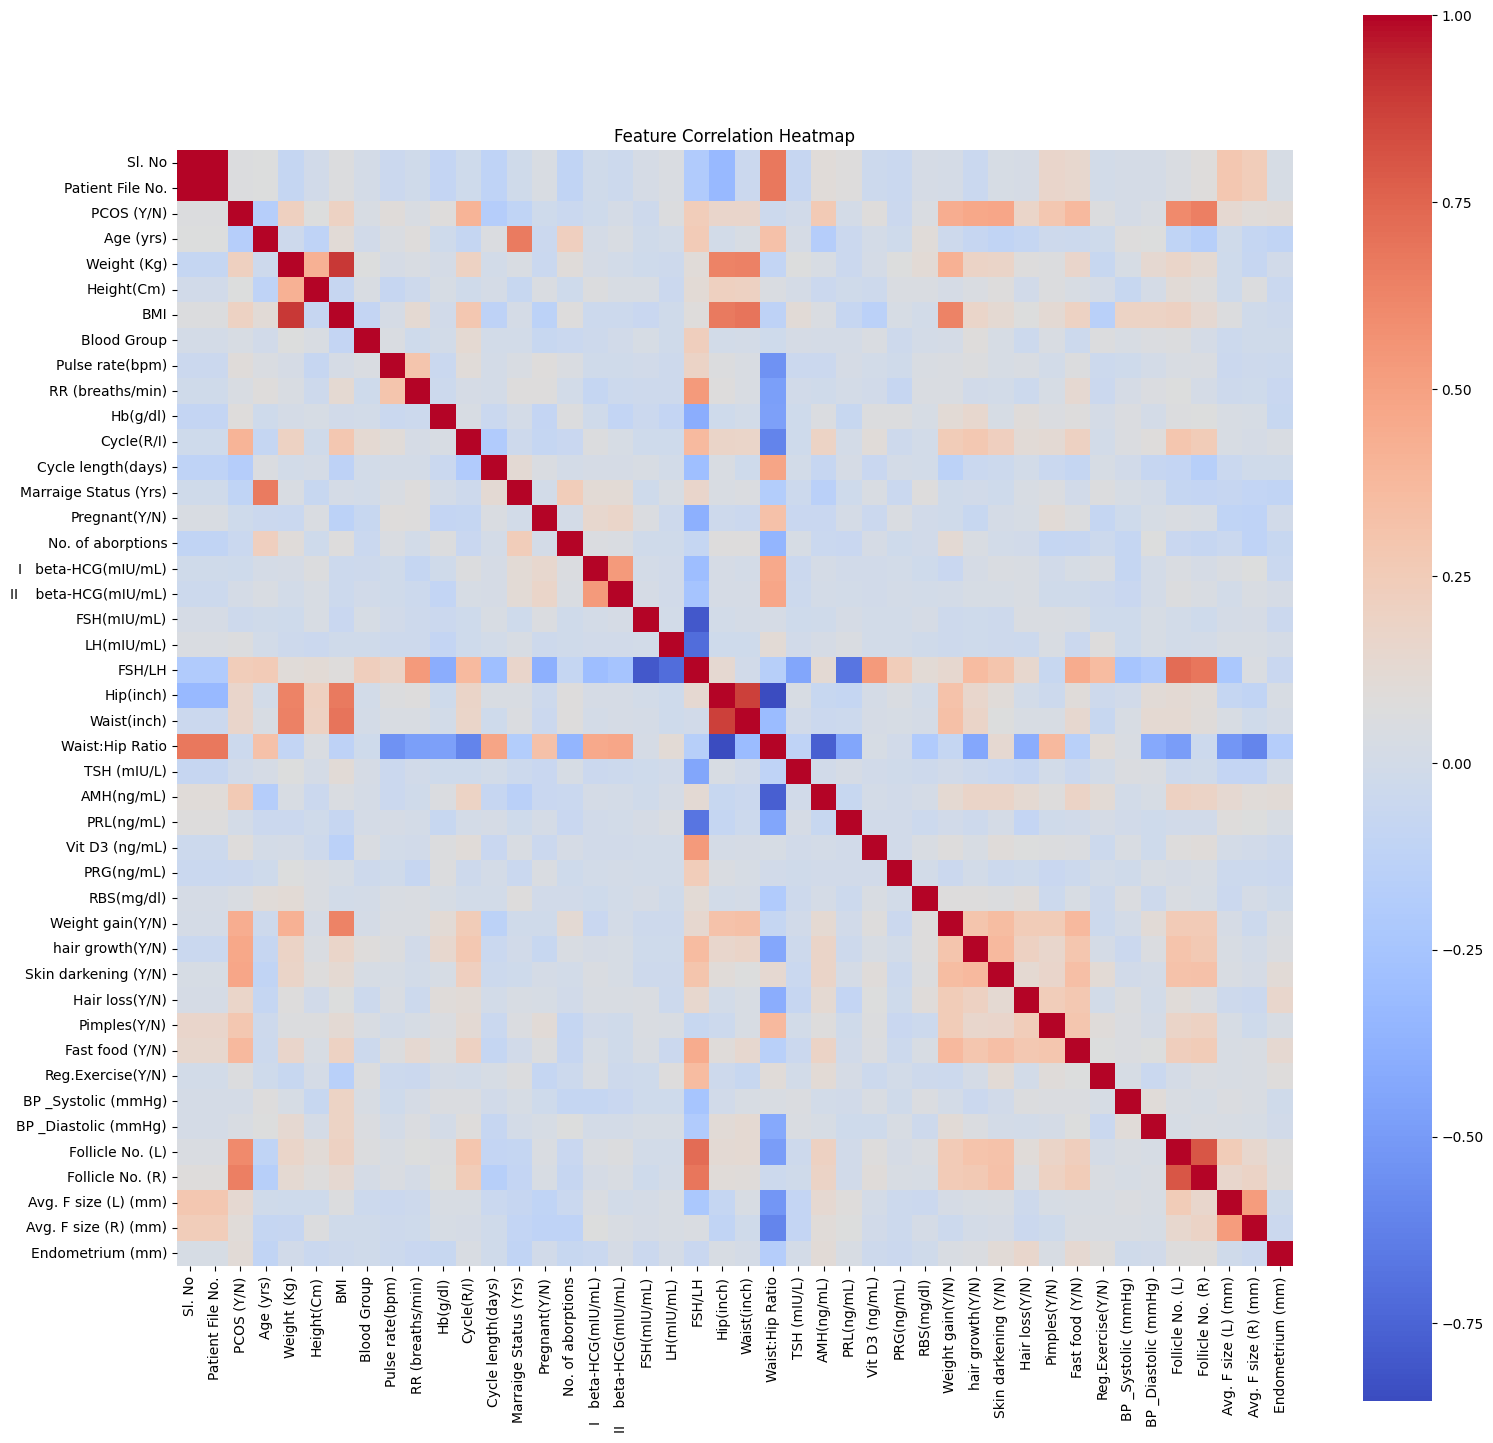

PCOS (Y/N)                1.000000
Follicle No. (R)          0.648327
Follicle No. (L)          0.603346
Skin darkening (Y/N)      0.475733
hair growth(Y/N)          0.464667
Weight gain(Y/N)          0.441047
Cycle(R/I)                0.401644
Fast food (Y/N)           0.376183
Pimples(Y/N)              0.286077
AMH(ng/mL)                0.264141
FSH/LH                    0.246457
Weight (Kg)               0.211938
BMI                       0.199223
Hair loss(Y/N)            0.172879
Waist(inch)               0.164598
Hip(inch)                 0.162297
Avg. F size (L) (mm)      0.132992
Endometrium (mm)          0.106648
Avg. F size (R) (mm)      0.097690
Pulse rate(bpm)           0.091821
Hb(g/dl)                  0.087170
Vit D3 (ng/mL)            0.085494
Height(Cm)                0.068254
Reg.Exercise(Y/N)         0.065337
LH(mIU/mL)                0.063879
Sl. No                    0.060998
Patient File No.          0.060998
RBS(mg/dl)                0.048922
BP _Diastolic (mmHg)

In [ ]:
# Compute correlation matrix
corrmat = data.corr()

# Plot the heatmap for visualization
plt.figure(figsize=(18, 18))
sns.heatmap(corrmat, cmap="coolwarm", annot=False, square=True)
plt.title("Feature Correlation Heatmap")
plt.show()

# Display correlation of all features with the target variable (PCOS)
pcos_corr = corrmat["PCOS (Y/N)"].sort_values(ascending=False)
print(pcos_corr)


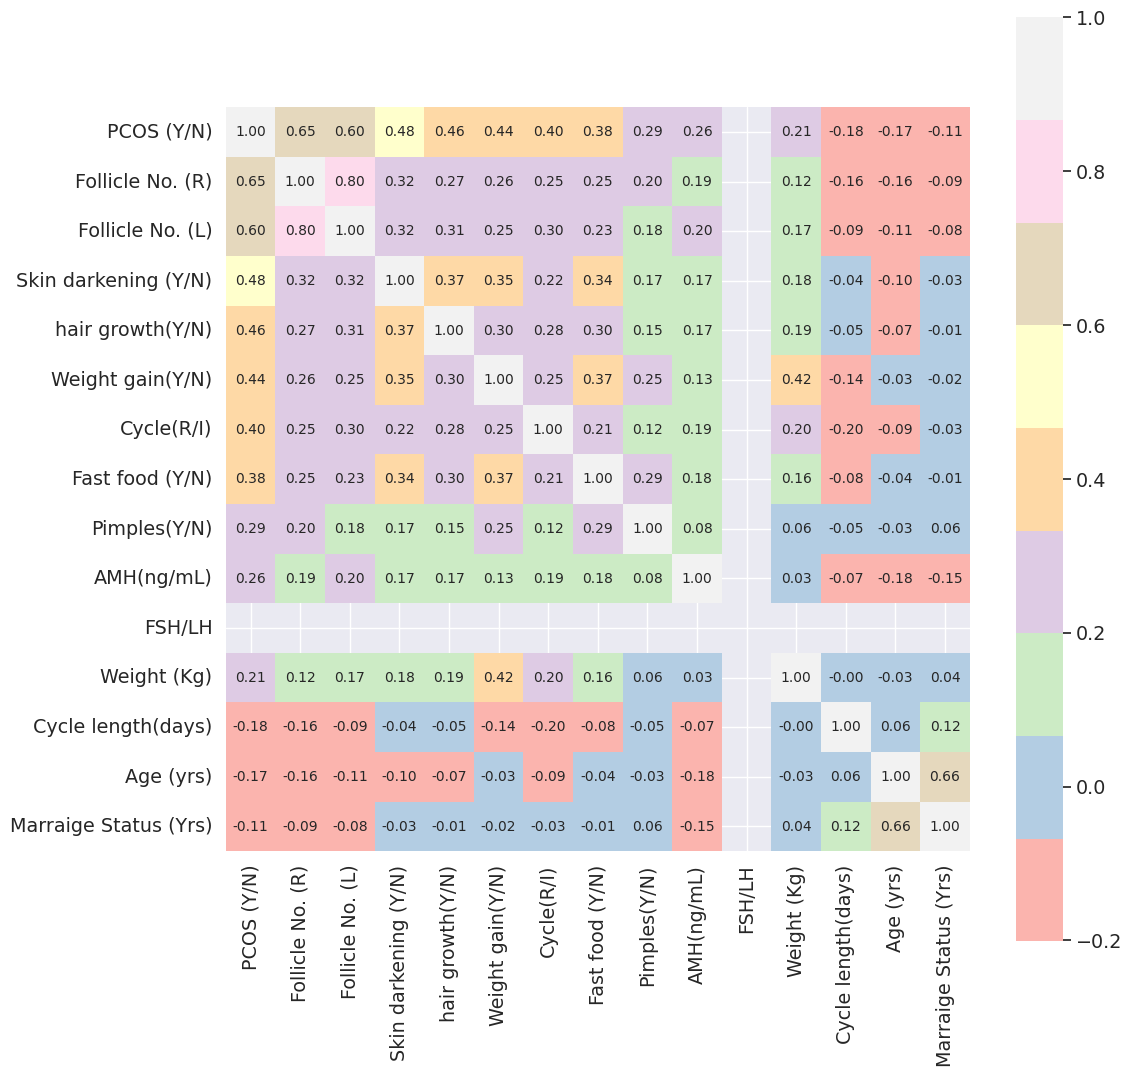

In [ ]:
corrmat = data.corr()
plt.figure(figsize=(12,12))

k = 12 #number of variables with positive for heatmap
l = 3 #number of variables with negative for heatmap
cols_p = corrmat.nlargest(k, "PCOS (Y/N)")["PCOS (Y/N)"].index
cols_n = corrmat.nsmallest(l, "PCOS (Y/N)")["PCOS (Y/N)"].index
cols = cols_p.append(cols_n)

cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True,cmap="Pastel1", annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

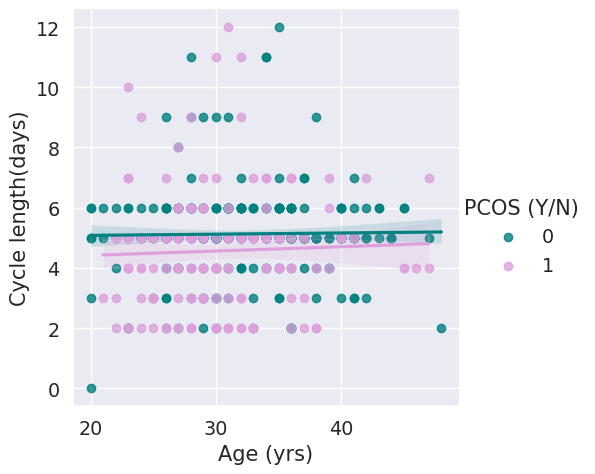

In [ ]:
# Length of menstrual phase in PCOS vs normal
color = ["teal", "plum"]
fig=sns.lmplot(data=data,x="Age (yrs)",y="Cycle length(days)", hue="PCOS (Y/N)",palette=color)
plt.show(fig)

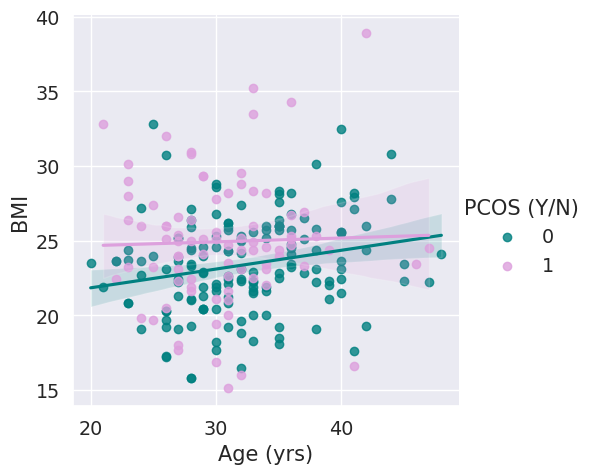

In [ ]:
# Pattern of weight gain (BMI) over years in PCOS and Normal.
fig= sns.lmplot(data =data,x="Age (yrs)",y="BMI", hue="PCOS (Y/N)", palette= color )
plt.show(fig)

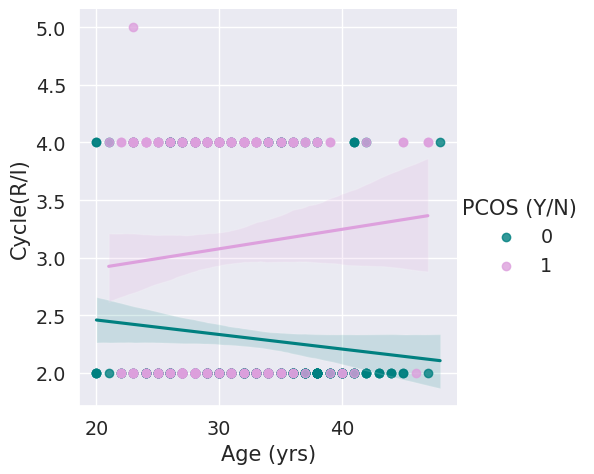

In [ ]:
# cycle IR wrt age
sns.lmplot(data =data,x="Age (yrs)",y="Cycle(R/I)", hue="PCOS (Y/N)",palette=color)
plt.show()

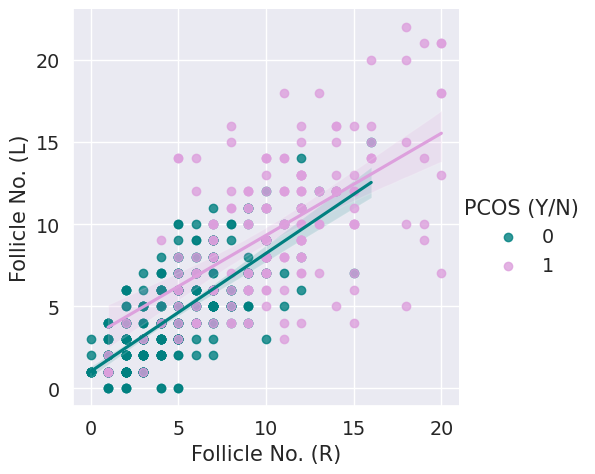

In [ ]:
# Distribution of follicles in both ovaries.
sns.lmplot(data =data,x='Follicle No. (R)',y='Follicle No. (L)', hue="PCOS (Y/N)",palette=color)
plt.show()

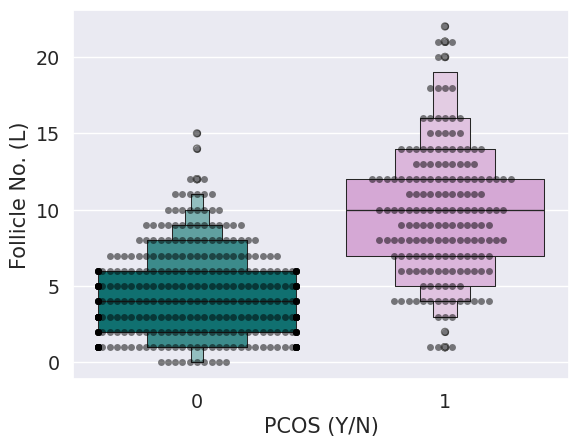

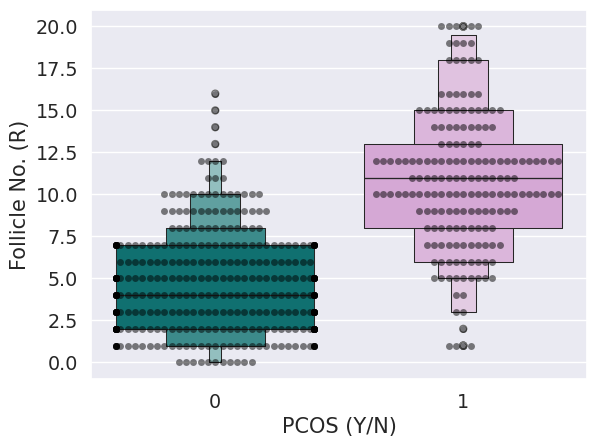

In [ ]:
features = ["Follicle No. (L)","Follicle No. (R)"]
for i in features:
    sns.swarmplot(x=data["PCOS (Y/N)"], y=data[i], color="black", alpha=0.5 )
    sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
    plt.show()

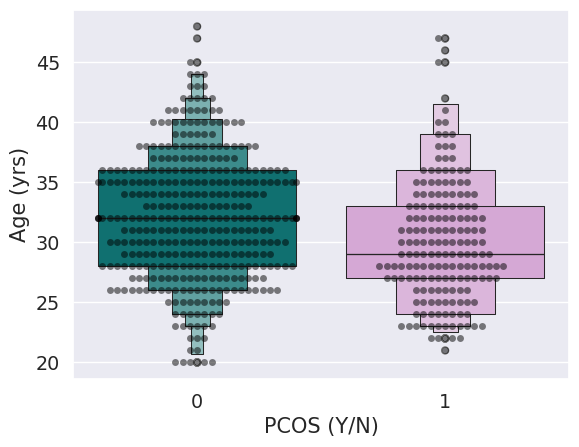

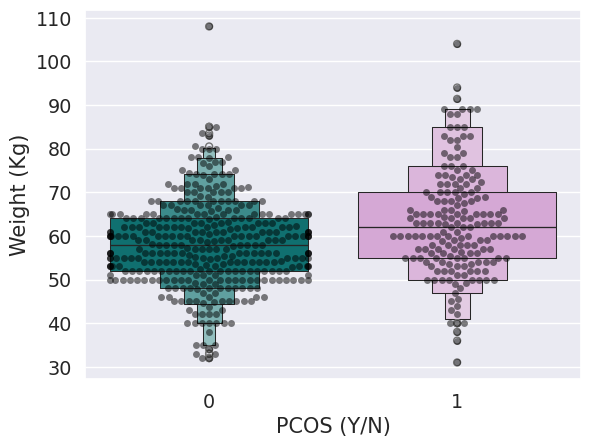

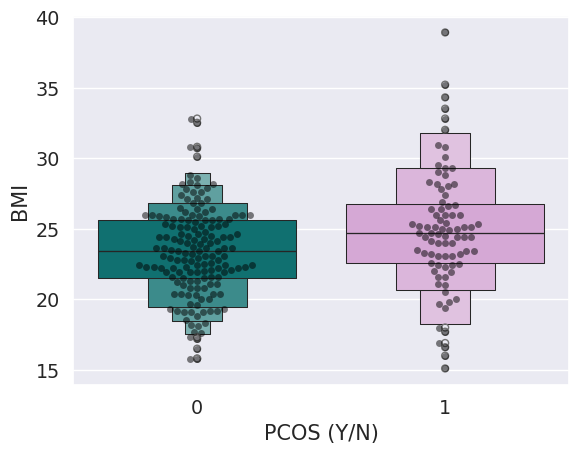

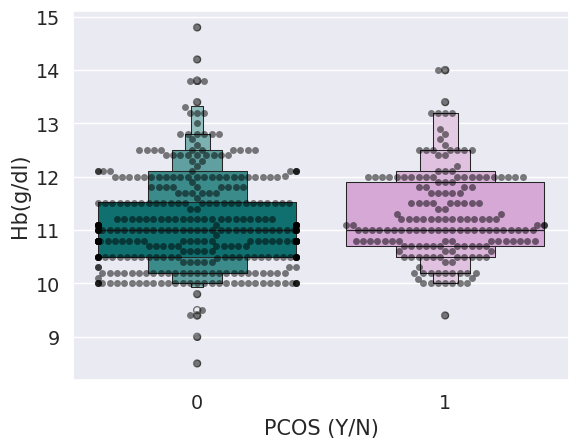

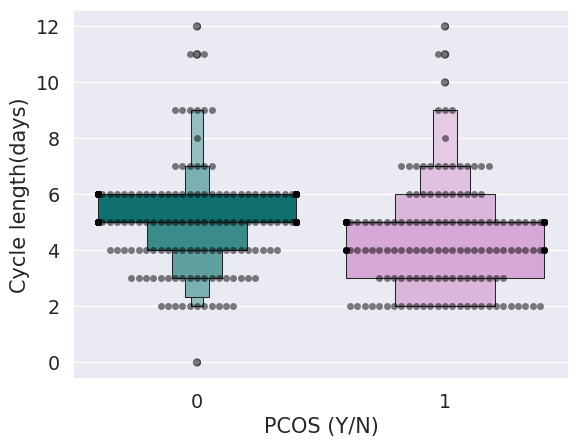

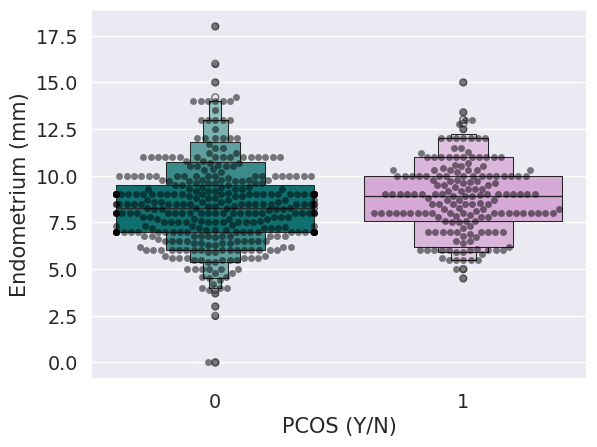

In [ ]:
features = ["Age (yrs)","Weight (Kg)", "BMI", "Hb(g/dl)", "Cycle length(days)","Endometrium (mm)" ]
for i in features:
    sns.swarmplot(x=data["PCOS (Y/N)"], y=data[i], color="black", alpha=0.5 )
    sns.boxenplot(x=data["PCOS (Y/N)"], y=data[i], palette=color)
    plt.show()

In [ ]:
# Selecting the top correlated features with PCOS
top_positive_features = pcos_corr.nlargest(10).index.tolist()  # 10 most positively correlated
top_negative_features = pcos_corr.nsmallest(3).index.tolist()  # 3 most negatively correlated

# Combine selected features (excluding the target variable itself)
selected_features = list(set(top_positive_features + top_negative_features))
selected_features.remove("PCOS (Y/N)")

# Display the selected features
print("Selected Features for Model Training:", selected_features)


Selected Features for Model Training: ['Skin darkening (Y/N)', 'AMH(ng/mL)', 'Pimples(Y/N)', 'Weight gain(Y/N)', 'Fast food (Y/N)', 'Age (yrs)', 'Follicle No. (R)', 'Cycle length(days)', 'Marraige Status (Yrs)', 'hair growth(Y/N)', 'Follicle No. (L)', 'Cycle(R/I)']


In [ ]:
# Defining X (features) and y (target variable)
X=data.drop(["PCOS (Y/N)","Sl. No","Patient File No."],axis = 1) #droping out index from features too
y = data["PCOS (Y/N)"]

# Splitting into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display the shape of the training and testing sets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (432, 41)
Testing set shape: (109, 41)


In [ ]:
# Handling missing values using median imputation
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Standardizing the dataset for models like Logistic Regression and SVM
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Data preprocessing completed: Missing values handled and features scaled.")


Data preprocessing completed: Missing values handled and features scaled.


Logistic Regression Accuracy: 0.9083
Random Forest Accuracy: 0.9174
SVM Accuracy: 0.8899
K-Nearest Neighbors Accuracy: 0.8899
Decision Tree Accuracy: 0.8807
Naive Bayes Accuracy: 0.8532

Best Performing Model: Random Forest with Accuracy 0.9174


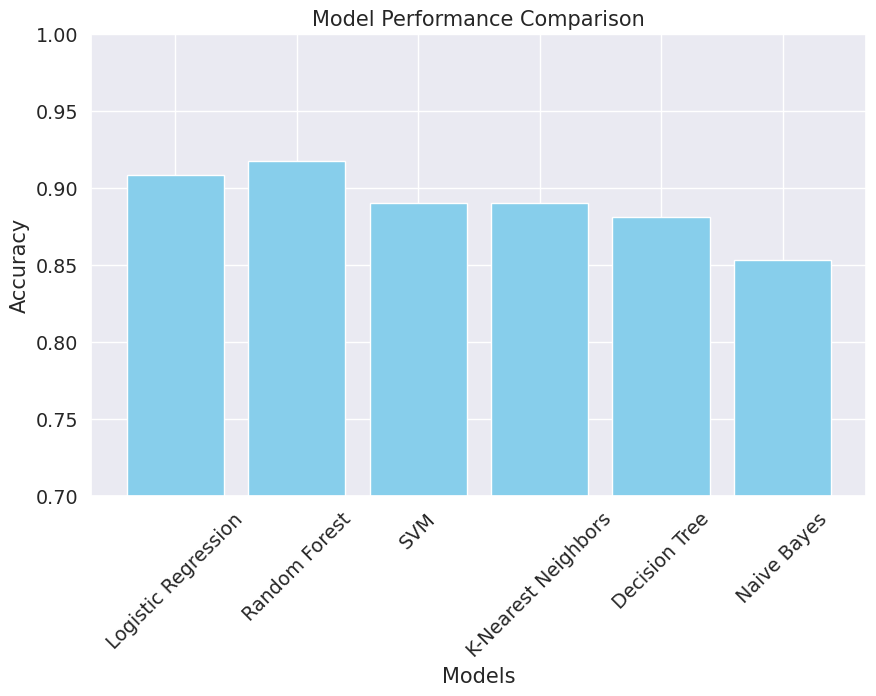

In [ ]:
# Define multiple models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}

# Train each model and evaluate accuracy
model_scores = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    accuracy = model.score(X_test, y_test)  # Evaluate on test set
    model_scores[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")

# Display the best-performing model
best_model_name = max(model_scores, key=model_scores.get)
print(f"\nBest Performing Model: {best_model_name} with Accuracy {model_scores[best_model_name]:.4f}")

# Visualize the performance of each model using a bar plot
plt.figure(figsize=(10,6))
plt.bar(model_scores.keys(), model_scores.values(), color='skyblue')
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1])  # Set y-axis limit for better comparison
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Hyperparameter tuning for Random Forest using GridSearchCV
rfc=RandomForestClassifier(n_estimators=100, random_state=42)
parameters = {
    'n_estimators': [100,150, 200,500,700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,9,10,12],
    'criterion' :['gini', 'entropy'],
    'n_jobs':[-1,1,None]
}

#Fitting the trainingset to find parameters with best accuracy

CV_rfc = GridSearchCV(estimator=rfc, param_grid=parameters, cv= 7)
CV_rfc.fit(X_train, y_train)

#Getting the outcome of gridsearch

CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'sqrt',
 'n_estimators': 200,
 'n_jobs': -1}

In [ ]:
#Fitting the model with selected parameters

rfc1=RandomForestClassifier(**CV_rfc.best_params_)
rfc1.fit(X_train, y_train)

#Testing the Model on test set

predictions=rfc1.predict(X_test)
acccuracy_final = accuracy_score(y_test,predictions)

acccuracy_final


0.926605504587156

In [ ]:
classi_report = classification_report(y_test, predictions)
print(classi_report)

              precision    recall  f1-score   support

           0       0.91      0.99      0.95        73
           1       0.97      0.81      0.88        36

    accuracy                           0.93       109
   macro avg       0.94      0.90      0.91       109
weighted avg       0.93      0.93      0.92       109



In [ ]:
# Saving the optimized Naive Bayes model using joblib
joblib.dump(best_nb_model, 'optimized_pcos_model.joblib')

# Saving the model using pickle as well
with open("optimized_pcos_model.pkl", "wb") as file:
    pickle.dump(best_nb_model, file)

print("Model has been saved successfully!")

NameError: name 'best_nb_model' is not defined